<h4 style="text-align: center;">NOTEBOOK</h4>
<p style="text-align: center; font-style: italic">~~ FETCH AND PREPARE DATA ~~</p>
</br>

<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Ce notebook a pour objectif de récupérer les données présentes sur le serveur selon les besoins de l'entraînement du/des modèles d'IA pour la détection des glyphes cunéiformes.</p>

</br>

<h3 style="text-align: justify; margin-left: 40px; margin-right: 80px;">
<b>Sommaire</b>
</h3>

<span style="margin-left: 80px;">- 1 - Récupérer les données et les images</span></br>
<span style="margin-left: 80px;">- 2 - Préparer les données en format YOLO, si utilisation ultérieur d'un modèle YOLO</span></br>

</br>

---
</br>

In [35]:
import base64
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
import sys

from ast import literal_eval
from io import BytesIO
from PIL import Image
from tqdm import tqdm

# - Import Personal Library
sys.path.append("../utils/")    ## - db_data_fetch
import db_data_fetch as dbdf

## GET DATA FROM DATABASE (annotation bbox and images)

In [46]:
SPLIT_SET = ['train', 'test']

df_train = pd.DataFrame()
df_test = pd.DataFrame()

train_images = pd.DataFrame()
test_images = pd.DataFrame()

#### Fetch Data Bbox Annotation

In [3]:
for param in SPLIT_SET:
    result = dbdf.fetch_data_bbox_annotation(param)

    if param == 'train':
        df_train = result
    elif param == 'test':
        df_test = result

#### Fetch Image

In [57]:
for param in SPLIT_SET:
    result = dbdf.fetch_image(param)

    if param == 'train':
        train_images = result
    elif param == 'test':
        test_images = result

#### Save dataframe in local

In [5]:
df_train.to_csv('data/train.csv', index=False)
df_test.to_csv('data/test.csv', index=False)

#### Decode tablet_picture, crop it to get each view and saved them on local in two folder (train and test)

In [7]:
def crop_img(img: Image.Image, bbox: np.ndarray) -> Image.Image:
    """Crop image reference to specific dimensions 
    with bbox (x_min, y_min, x_max, y_max) in numpy array format"""
    return img.crop((bbox[0], bbox[1], bbox[2], bbox[3]))

##### └── Train

In [15]:
directory = 'data/train_tablets_image/'

## - Convert the bbox_segment to a numpy array for the crop_img function
train_images['bbox_segment'] = train_images['bbox_segment']\
                               .apply(literal_eval).apply(np.array)

for index, row in tqdm(train_images.iterrows(), total=train_images.shape[0]):
    picture_data = row['tablet_picture']
    binary_data = base64.b64decode(picture_data)

    image = Image.open(BytesIO(binary_data))
    tablet_view = crop_img(image, row['bbox_segment'])

    if not os.path.exists(directory):
        os.makedirs(directory)

    tablet_view.save(os.path.join(directory, f'{row["tablet_name"]}.jpg'))

    # tablet_view.show()

100%|██████████| 132/132 [00:14<00:00,  9.04it/s]


##### └── Test

In [17]:
directory = 'data/test_tablets_image/'

## - Convert the bbox_segment to a numpy array for the crop_img function
test_images['bbox_segment'] = test_images['bbox_segment']\
                               .apply(literal_eval).apply(np.array)

for index, row in tqdm(test_images.iterrows(), total=test_images.shape[0]):
    picture_data = row['tablet_picture']
    binary_data = base64.b64decode(picture_data)

    image = Image.open(BytesIO(binary_data))
    tablet_view = crop_img(image, row['bbox_segment'])

    if not os.path.exists(directory):
        os.makedirs(directory)

    tablet_view.save(os.path.join(directory, f'{row["tablet_name"]}.jpg'))

    # tablet_view.show()

100%|██████████| 112/112 [00:09<00:00, 11.51it/s]


##### └── Check result crop with csv information

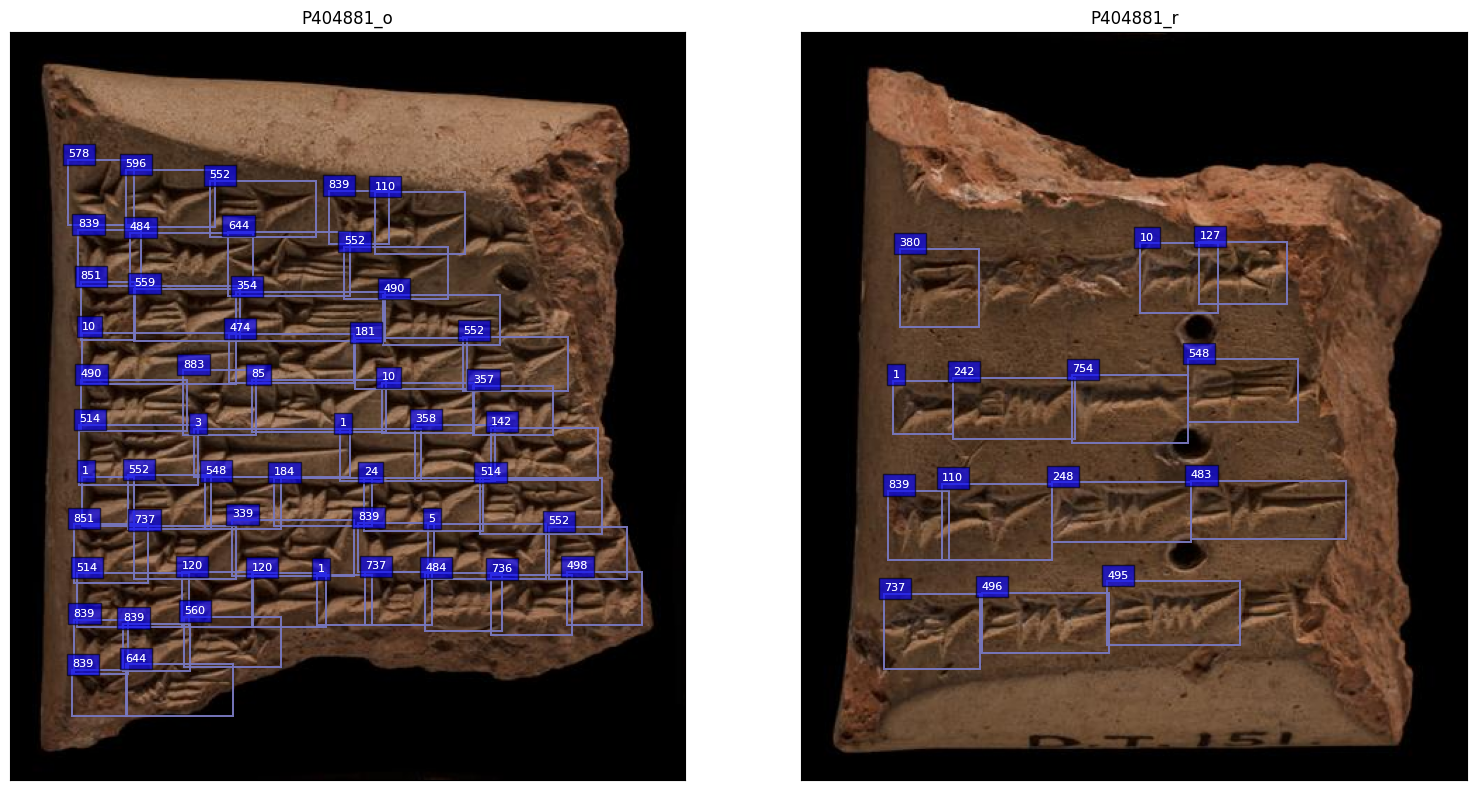

In [25]:
df_train = pd.read_csv('data/train.csv')
df_train = df_train[df_train['tablet_name'].isin(['P404881_o', 'P404881_r'])]

df_train['bbox_glyph'] = df_train['bbox_glyph']\
    .apply(literal_eval).apply(np.array)

path_tablet_o = "data/train_images/P404881_o.jpg"
path_tablet_r = "data/train_images/P404881_r.jpg"


def plot_boxes(boxes: np.ndarray, labels: np.ndarray, ax: plt.Axes) -> None:
    for idx, bbox in enumerate(boxes):
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]), 
                           bbox[2] - bbox[0], 
                           bbox[3] - bbox[1],
                          fill=False, 
                          edgecolor='#7878bf', 
                          alpha=0.8, 
                          linewidth=1.4))

        ax.text(bbox[0], bbox[1] - 2, f"{labels[idx]}",
                bbox=dict(facecolor='blue', alpha=0.4), 
                fontsize=8, color='white')


fig, ax = plt.subplots(1, 2, figsize=(16, 8))
for idx, occurrence in enumerate(['P404881_o', 'P404881_r']):
    path_tablet = path_tablet_o if occurrence == 'P404881_o' else path_tablet_r
    pil_im = Image.open(path_tablet)

    selected_data = df_train[df_train['tablet_name'] == occurrence]

    for s_idx, s_rec in selected_data.iterrows():
        ax[idx].imshow(np.asarray(pil_im))
        ax[idx].set_title(f"{s_rec['tablet_name']}")
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])

        sign_bboxes = [s_rec['bbox_glyph']]
        sign_lbls = [s_rec['mzl_label']]

        plot_boxes(sign_bboxes, sign_lbls, ax=ax[idx])

plt.tight_layout()
plt.show()

#### Decode tablet_picture, crop it by glyph and saved them on local in two folder (train and test) then classified by mzl in folder also

In [71]:
def crop_img(img: Image.Image, bbox: np.ndarray) -> Image.Image:
    """Crop image reference to specific dimensions 
    with bbox (x_min, y_min, x_max, y_max) in numpy array format"""
    return img.crop((bbox[0], bbox[1], bbox[2], bbox[3]))

##### └── Train

In [103]:
train_annotations = pd.read_csv('data/train.csv')
train_image_directory = 'data/train_images/'
save_directory = 'data/train_glyphs_image/'

# - !!! Don't comment this line !!!
train_annotations['bbox_glyph'] = train_annotations['bbox_glyph']\
                                  .apply(literal_eval).apply(np.array)

## - Crop by glyph (bbox_glyph), iterate for each glyph in the tablet
for idx, row_glyph in train_annotations[train_annotations['tablet_name'] == row_tablet['tablet_name']].iterrows():
    glyph_view = crop_img(tablet_view, row_glyph['bbox_glyph'])
    mzl_directory = os.path.join(directory, str(row_glyph['mzl_label']))

    if not os.path.exists(mzl_directory):
        os.makedirs(mzl_directory)

    num_files = len([name for name in os.listdir(mzl_directory) 
                            if os.path.isfile(os.path.join(mzl_directory, 
                                                            name))])
    glyph_filename = f"{row_glyph['mzl_label']}_{num_files + 1}.jpg"
    glyph_view.save(os.path.join(mzl_directory, glyph_filename))

        # glyph_view.show()

 41%|████      | 54/132 [00:19<00:28,  2.75it/s]


KeyboardInterrupt: 

##### └── Test

In [101]:
test_annotations = pd.read_csv('data/test.csv')
directory = 'data/test_glyphs_image/'

# - Convert the bbox_segment to a numpy array for the crop_img function
# test_images['bbox_segment'] = test_images['bbox_segment']\
#                                .apply(literal_eval).apply(np.array)

# - !!! Don't comment this line !!!
test_annotations['bbox_glyph'] = test_annotations['bbox_glyph']\
                                  .apply(literal_eval).apply(np.array)

for index, row_tablet in tqdm(test_images.iterrows(), 
                              total=test_images.shape[0]):
    picture_data = row_tablet['tablet_picture']
    binary_data = base64.b64decode(picture_data)

    ## - Crop by view (bbox_segment)
    image = Image.open(BytesIO(binary_data))
    tablet_view = crop_img(image, row_tablet['bbox_segment'])

    ## - Crop by glyph (bbox_glyph), iterate for each glyph in the tablet
    for idx, row_glyph in test_annotations[test_annotations['tablet_name'] == row_tablet['tablet_name']].iterrows():
        glyph_view = crop_img(tablet_view, row_glyph['bbox_glyph'])
        mzl_directory = os.path.join(directory, str(row_glyph['mzl_label']))

        if not os.path.exists(mzl_directory):
            os.makedirs(mzl_directory)

        num_files = len([name for name in os.listdir(mzl_directory) 
                                  if os.path.isfile(os.path.join(mzl_directory, 
                                                                 name))])
        glyph_filename = f"{row_glyph['mzl_label']}_{num_files + 1}.jpg"
        glyph_view.save(os.path.join(mzl_directory, glyph_filename))

        # glyph_view.show()

100%|██████████| 112/112 [00:43<00:00,  2.57it/s]


------------
## FOR YOLO (prepare data if need to perform an YOLO model)

##### Prepare/Create folder

In [30]:
yolo_directory = 'data/yolo_data/'
images_train_yolo = f'{yolo_directory}train/images/'
labels_train_yolo = f'{yolo_directory}train/labels/'
images_valid_yolo = f'{yolo_directory}valid/images/'
labels_valid_yolo = f'{yolo_directory}valid/labels/'

directories_to_create = [
    yolo_directory,
    images_train_yolo,
    labels_train_yolo,
    images_valid_yolo,
    labels_valid_yolo
]

for directory in directories_to_create:
    if not os.path.exists(directory):
        os.makedirs(directory)


##### Copy Images in the Yolo folder (don't move just copy to keep raw)

In [31]:
train_images = 'data/train_images/'
test_images = 'data/test_images/'

## - Train Images
for filename in os.listdir(train_images):
    src = os.path.join(train_images, filename)
    dst = os.path.join(images_train_yolo, filename)
    shutil.copyfile(src, dst)

## - Test Images
for filename in os.listdir(test_images):
    src = os.path.join(test_images, filename)
    dst = os.path.join(images_valid_yolo, filename)
    shutil.copyfile(src, dst)

##### Encoded mzl_label to fit with number of labels used in training

In [32]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

df_train['mzl_encoded'] = pd.Categorical(df_train['mzl_label']).codes
df_test['mzl_encoded'] = pd.Categorical(df_test['mzl_label']).codes

df_train.to_csv('data/yolo_data/train_yolo.csv', index=False)
df_test.to_csv('data/yolo_data/test_yolo.csv', index=False)

##### Create the labels file in YOLO format

In [33]:
def preprocess_data(csv_path: str, images_path: str, labels_yolo_path: str) -> None:
    """Preprocess the data and save it in YOLO format"""
    df = pd.read_csv(csv_path)
    df['bbox_glyph'] = df['bbox_glyph'].apply(literal_eval).apply(np.array)


    for index, row in df.iterrows():
        ## - Get row information
        tablet_name = row["tablet_name"]
        bbox_glyph_x, bbox_glyph_y, bbox_glyph_width, bbox_glyph_height = row["bbox_glyph"]
        mzl_encoded = row["mzl_encoded"]

        ## - Get the image size
        image_path = os.path.join(images_path, tablet_name + '.jpg')
        image = Image.open(image_path)
        img_width, img_height = image.size

        ## - Convert in YOLO format
        x_center = (bbox_glyph_x + bbox_glyph_width) / 2
        y_center = (bbox_glyph_y + bbox_glyph_height) / 2

        x_center_yolo = round(x_center / img_width, 6)
        y_center_yolo = round(y_center / img_height, 6)
        width_yolo = round(bbox_glyph_width / img_width, 6)
        height_yolo = round(bbox_glyph_height / img_height, 6)

        # print(x_center_yolo, y_center_yolo, width_yolo, height_yolo)

        # ## - Save label and yolo bbox in file
        output_file = os.path.join(labels_yolo_path, f"{tablet_name}.txt")
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        with open(output_file, "a") as file:
            file.write(f"{mzl_encoded} {x_center_yolo} {y_center_yolo} {width_yolo} {height_yolo}\n")


preprocess_data('data/yolo_data/train_yolo.csv', train_images, labels_train_yolo)
preprocess_data('data/yolo_data/test_yolo.csv', test_images, labels_valid_yolo)

##### Create the custom.yaml

In [34]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

## - Get all the classes
all_classes = sorted(pd.concat([df_train['mzl_label'], 
                                df_test['mzl_label']]).unique().tolist())

## - Create the yaml variable
## ---- Colab variable
# path = "path: /content/drive/MyDrive/projet_Assyr/training_data/yolo_data"
# train = "train: train/images"
# val = "val: valid/images"
# nc = f"nc: {len(all_classes)}"
# names = f"names: {[str(cls) for cls in all_classes]}"

## ---- Local variable
path = "path: data/yolo_data"
train = "train: train/images"
val = "val: valid/images"
nc = f"nc: {len(all_classes)}"
names = f"names: {[str(cls) for cls in all_classes]}"

with open('data/yolo_data/custom.yaml', 'w') as file:
    # yaml.dump(yolo_config, file, default_flow_style=False, sort_keys=False)
    file.write(f"{path}\n{train}\n{val}\n\n{nc}\n{names}")